In [1]:
from pathlib import Path
import os
import numpy as np
import scipy.io

import matplotlib.pyplot as plt
import h5py

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

batch_size = 16
num_classes = 6
learning_rate = 0.002
num_epochs = 1000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def load_h5py_to_tensors(file_path, dataset_name, train=True):
    """
    Args:
        file_path (str): Path to the HDF5 file.
        dataset_name (str): Name of the dataset inside the HDF5 file.
        train (bool): Whether to load the train or test dataset.
    """

    # Open the file in read mode and get the dataset
    with h5py.File(file_path, 'r') as h5_file:
        if train:
            # The datasets have shape (6, N); we need to transpose them to get (N, 6)
            data = torch.tensor(h5_file[dataset_name]['train_x'][()], dtype=torch.float32).T
            # Convert one-hot encoded labels to class indices
            labels = torch.tensor(h5_file[dataset_name]['train_y'][()], dtype=torch.long).T.argmax(dim=1)
        else:
            data = torch.tensor(h5_file[dataset_name]['test_x'][()], dtype=torch.float32).T
            labels = torch.tensor(h5_file[dataset_name]['test_y'][()], dtype=torch.long).T.argmax(dim=1)

    return TensorDataset(data, labels)

In [3]:
# Load and Prepare the Data
train_dataset = load_h5py_to_tensors("nature_paper_materials/Fig4.h5", "Vowel data", train=True)

test_dataset = load_h5py_to_tensors("nature_paper_materials/Fig4.h5", "Vowel data", train=False)

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = batch_size,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                            batch_size = batch_size,
                                            shuffle = False)

In [4]:
# Define the MLP Model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(6, 6, bias=False, dtype=torch.float64)
        self.fc2 = nn.Linear(6, 6, bias=False, dtype=torch.float64)
        self.fc3 = nn.Linear(6, 6, bias=False, dtype=torch.float64)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [5]:
# Set Up Loss, Optimizer, and Scheduler
model = MLP().to(device)
    
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Use ReduceLROnPlateau scheduler on the test (validation) loss
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.99, patience=10)

In [6]:
# Training Loop with Validation Metrics
test_losses = []
test_accuracies = []
epochs = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device, dtype=torch.float64)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluation on the test set after each epoch
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device, dtype=torch.float64)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct / total

    # Record metrics
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)
    epochs.append(epoch + 1)

    # Step the scheduler based on test loss
    scheduler.step(avg_test_loss)

    # Print metrics every 50 epochs
    if (epoch + 1) % 50 == 0:
        avg_train_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, "
              f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Epoch [50/1000], Train Loss: 0.5454, Test Loss: 0.6627, Test Accuracy: 75.51%
Epoch [100/1000], Train Loss: 0.2654, Test Loss: 0.4859, Test Accuracy: 81.63%
Epoch [150/1000], Train Loss: 0.2155, Test Loss: 0.5017, Test Accuracy: 82.99%
Epoch [200/1000], Train Loss: 0.1924, Test Loss: 0.5238, Test Accuracy: 84.69%
Epoch [250/1000], Train Loss: 0.1775, Test Loss: 0.5608, Test Accuracy: 86.39%
Epoch [300/1000], Train Loss: 0.1656, Test Loss: 0.5699, Test Accuracy: 88.10%
Epoch [350/1000], Train Loss: 0.1555, Test Loss: 0.5928, Test Accuracy: 87.76%
Epoch [400/1000], Train Loss: 0.1454, Test Loss: 0.6260, Test Accuracy: 88.10%
Epoch [450/1000], Train Loss: 0.1336, Test Loss: 0.6407, Test Accuracy: 87.76%
Epoch [500/1000], Train Loss: 0.1260, Test Loss: 0.6356, Test Accuracy: 88.10%
Epoch [550/1000], Train Loss: 0.1201, Test Loss: 0.6573, Test Accuracy: 88.44%
Epoch [600/1000], Train Loss: 0.1133, Test Loss: 0.6760, Test Accuracy: 88.10%
Epoch [650/1000], Train Loss: 0.1096, Test Loss: 0.68

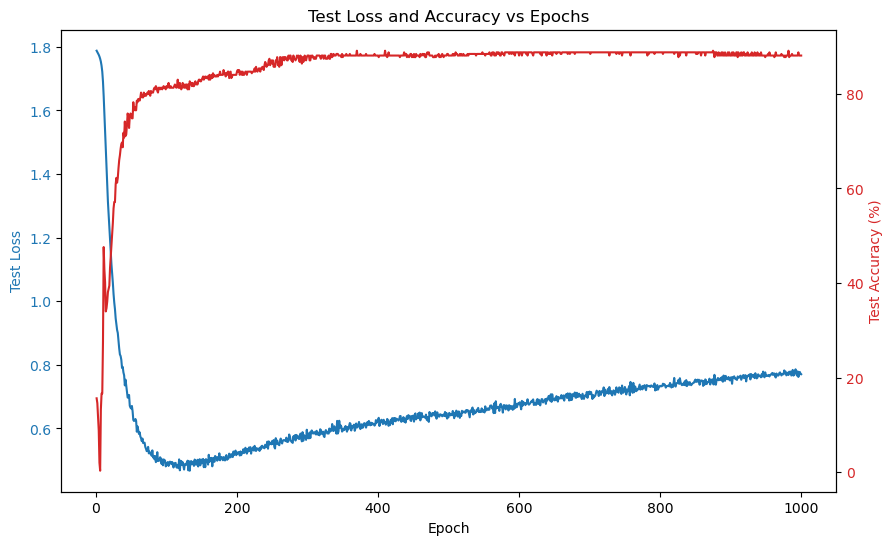

In [8]:
# Plot Test Loss and Accuracy
fig, ax1 = plt.subplots(figsize=(10, 6))

color_loss = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Test Loss', color=color_loss)
ax1.plot(epochs, test_losses, color=color_loss, label='Test Loss')
ax1.tick_params(axis='y', labelcolor=color_loss)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color_acc = 'tab:red'
ax2.set_ylabel('Test Accuracy (%)', color=color_acc)
ax2.plot(epochs, test_accuracies, color=color_acc, label='Test Accuracy')
ax2.tick_params(axis='y', labelcolor=color_acc)

plt.title('Test Loss and Accuracy vs Epochs')
plt.show()

In [9]:
test_losses[-1]

0.7705073664322781

In [10]:
superdnn_metrics = {
    'epochs': epochs,
    'test_loss': test_losses,
    'test_acc': test_accuracies
}
torch.save(superdnn_metrics, os.path.join("results/", "superdnn_metrics.pt"))

In [12]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        inputs = inputs.to(device, dtype=torch.float64)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Test Accuracy: {100 * correct / total:.2f} %')

Test Accuracy: 88.10 %


In [13]:
checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }
torch.save(checkpoint, os.path.join("results/", "superdnn_model.pt"))

In [14]:
tensors_to_save = {}
for key, tensor in model.state_dict().items():
    tensors_to_save[key.replace(".", "_")] = tensor.cpu().numpy()
print(tensors_to_save)
scipy.io.savemat(os.path.join("results", "superdnn_weights.mat"), tensors_to_save)

{'fc1_weight': array([[ 1.06929157,  1.84732333,  0.44521296, -0.07963991,  2.73611771,
        -0.18679731],
       [-2.11115489,  0.67345462,  1.5110576 , -0.73414266, -0.46385499,
         1.46368892],
       [ 0.34881125,  0.10256999,  0.09515733, -0.29870918, -0.38133911,
        -0.30298859],
       [-0.2653425 , -0.28709326, -0.26957297,  0.27873999,  0.24169679,
        -0.30423852],
       [ 1.74487424, -0.71628801, -0.20965081,  1.95984449, -0.79240993,
        -0.04949559],
       [ 0.7225218 , -0.28097884,  0.52800198,  2.01801246, -1.72277589,
         0.86008127]]), 'fc2_weight': array([[ 6.25310943e-01, -3.65987601e+00,  2.38383821e-01,
         1.12087074e-01,  1.59303871e+00, -1.00930171e-01],
       [ 1.44088707e+00,  1.28406531e+00,  7.59742317e-03,
         1.66734465e-01, -1.48931954e+00, -5.16903830e-01],
       [-3.94564323e-01,  1.90257668e-01, -1.10035289e-03,
        -6.03086968e-02,  2.39398347e+00,  2.38786423e+00],
       [ 1.42623535e+00, -2.46083199e+00, 